In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    HyperparameterTuner,
)

from src import fetch_bucketed_from_bitmex, preprocess, evaluate, train_linear, train_lstm

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Crawling the Dataset

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

# Feature Engineering

In [3]:
preprocess(df, input_dir)

# Training

### Benchmark: Linear Model

In [2]:
train_linear(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    hidden_dim=64,
    lr=1e-3,
    batch_size=1024,
    n_epochs=16,
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 1.411e+00 | 1.398e-01 |      0 |
|     1 | 1.225e+00 | 1.716e-01 |      0 |
|     2 | 1.069e+00 | 2.158e-01 |      0 |
|     3 | 9.351e-01 | 2.704e-01 |      0 |
|     4 | 8.343e-01 | 2.762e-01 |      0 |
|     5 | 8.238e-01 | 2.820e-01 |      0 |
|     6 | 8.137e-01 | 2.876e-01 |      0 |
|     7 | 8.038e-01 | 2.933e-01 |      0 |
|     8 | 7.955e-01 | 2.939e-01 |      0 |
|     9 | 7.945e-01 | 2.944e-01 |      0 |
|    10 | 7.936e-01 | 2.950e-01 |      0 |
|    11 | 7.926e-01 | 2.955e-01 |      0 |
|    12 | 7.918e-01 | 2.956e-01 |      0 |
|    13 | 7.917e-01 | 2.956e-01 |      0 |
|    14 | 7.916e-01 | 2.957e-01 |      0 |
|    15 | 7.916e-01 | 2.957e-01 |      0 |
loss of trai is 7.915e-01
loss of vali is 2.957e-01
loss of test is 1.562e+00


### Solution: LSTM Model

In [6]:
# train_lstm(
#     input_dir=input_dir,
#     output_dir=output_dir,
#     model_dir=model_dir,
#     hidden_dim=256,
#     lstm_layers=2,
#     dropout=0.1,
#     lr=1e-3,
#     batch_size=1024,
#     n_epochs=4,
# )

inputs = sagemaker_session.upload_data(
    path=input_dir, bucket=bucket, key_prefix="lstm-trader"
)

estimator = PyTorch(
    source_dir="src",
    entry_point="trainer_lstm.py",
    hyperparameters={
        "hidden-dim": 256,
        "lstm-layers": 2,
        "dropout": 0.1,
        "lr": 1e-3,
        "batch-size": 1024,
        "n-epochs": 16,
    },
    framework_version="1.2.0",
    role=role,
    sagemaker_session=sagemaker_session,
    train_instance_count=1,
    train_instance_type="ml.p2.xlarge",
)

estimator.fit({"data_dir": inputs})

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 8.323e-01 | 4.359e-01 |      8 |
|     1 | 3.724e-01 | 4.884e-01 |     10 |
|     2 | 3.572e-01 | 3.635e-01 |      9 |
|     3 | 1.894e-01 | 3.028e-01 |      9 |
loss of trai is 2.616e-01
loss of vali is 3.032e-01
loss of test is 1.168e+00


In [3]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="test loss",
    hyperparameter_ranges={
        "hidden-dim": IntegerParameter(8, 128),
    },
    metric_definitions=[
        {"Name": "test loss", "Regex": "loss of test is ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+))"}
    ],
    max_jobs=16,
    max_parallel_jobs=1,
    objective_type="Minimize",
)

tuner.fit({"data_dir": inputs})

In [4]:
sagemaker_session.download_data(
    path=model_dir,
    bucket=bucket,
    key_prefix=estimator.latest_training_job.name + "/output/model.tar.gz",
)
!tar xvf cache_model/model.tar.gz --directory=cache_model

lstm.pth


# Evaluation

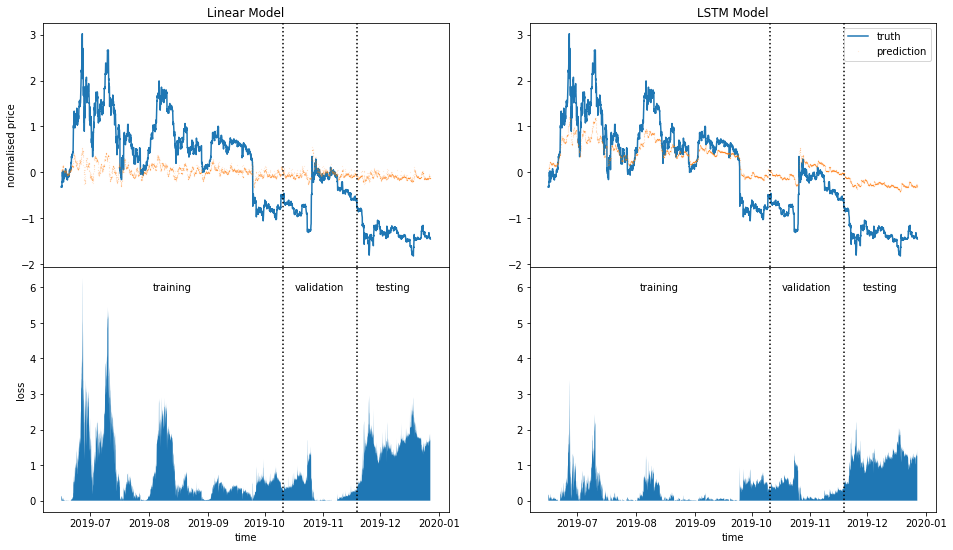

In [7]:
evaluate(input_dir, output_dir)